# Part 2 - Data Wrangling
---
### Papers Past Topic Modeling

<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc, subprocess
sys.path.insert(0, '../utils')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from pyspark.sql import functions as F
from pyspark.sql.types import *
from utils import conf_pyspark, load_dataset
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.driver.host', 'x99.hub'),
 ('spark.app.id', 'local-1548706413589'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '44368'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

## 1 Load Data

**Load raw dataset:**

In [2]:
df = load_dataset('raw', spark)
#df.cache();

In [3]:
nrow_raw = df.count()
print('Shape of dataframe: ({}, {})'.format(nrow_raw, len(df.columns)))
df.limit(5).toPandas().head()

Shape of dataframe: (16731578, 6)


,id,url,publisher,time,title,content
0,10000044,http://api.digitalnz.org/records/10000044/source,Timaru Herald,1890-01-23T00:00:00.000Z,"Page 4 Advertisements Column 4 (Timaru Herald, 23 January 1890)","f^BAXEytJIi — OOMFOBTINO EPPS'S~OOCOA. BBEAKffABT. ""By & thorough knowledge of ths natural laws which govern the ope..."
1,10000275,http://api.digitalnz.org/records/10000275/source,Timaru Herald,1890-01-24T00:00:00.000Z,"Page 1 Advertisements Column 5 (Timaru Herald, 24 January 1890)","Tl/rONBY TO LEND on Approved Freehold Seourity, IN SUMS TO SUIT BOBBOWBBS. Apply to — PBRBY &PBBRY, Bolioitors, Tima..."
2,10000407,http://api.digitalnz.org/records/10000407/source,Timaru Herald,1890-01-24T00:00:00.000Z,"ABSTRACT OF SALES BY AUCTION. (Timaru Herald, 24 January 1890)","ABSTRACT OF SALES BY AUCTION.|3ek advertisements. | This Day. By Tnrnbnll mid Sou, at tho residence of Mr ,T. Wood, ..."
3,10000420,http://api.digitalnz.org/records/10000420/source,Timaru Herald,1890-01-24T00:00:00.000Z,"MEETINGS. AMUSEMENTS, Etc. (Timaru Herald, 24 January 1890)","MEETINGS. AMUSEMENTS, Etc.This Day. Thoatro Royal — "" Sweot Lavender,"" at 8 p.m. Tho Hospital— S.C. Hospital and Cha..."
4,10000450,http://api.digitalnz.org/records/10000450/source,Timaru Herald,1890-01-24T00:00:00.000Z,"TRAINS ARRIVE AT TIMAEU. (Timaru Herald, 24 January 1890)","TRAINS ARRIVE AT TIMAEU.From F.iirlio Creole, 10.30 n.tn. From North— Orari, 0.50 a.m. (Saturdays t'rom Eangitata) ;..."


## 2 Clean Data

### 2.1 Missing Values

**Check empty values:**

In [5]:
# Count null
print('Print Null:')
df.select([F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c))
           .alias(c) for c in df.columns]).show()

Print Null:
+---+---+---------+----+-----+-------+
| id|url|publisher|time|title|content|
+---+---+---------+----+-----+-------+
|  0|  0|        0|   0|    0|  56232|
+---+---+---------+----+-----+-------+



**Drop rows with empty document:**

In [3]:
# Clean NA to avoid nonetype.
df = df.na.drop(subset=['content'])

### 2.2 Duplicate Values

**The "id" should be unique, check duplication:**

In [7]:
print('Duplicated id number: ', nrow_raw - df.select('id').distinct().count())

Duplicated id number:  543700


**There are duplicated "id" in the dataset, show three of them:**

In [8]:
df.groupBy('id').count().where(F.col('count')>1).show(3)

+--------+-----+
|      id|count|
+--------+-----+
|11642926|    2|
|11651057|    2|
|11709006|    2|
+--------+-----+
only showing top 3 rows



**Select the first one to check detail:**

In [9]:
df.filter(df.id == 10036037).toPandas().head()

,id,url,publisher,time,title,content
0,10036037,http://api.digitalnz.org/records/10036037/source,Poverty Bay Herald,1898-01-06T00:00:00.000Z,"THE EASTERN SITUATION (Poverty Bay Herald, 06 January 1898)","THE EASTERN SITUATION'Octis"" in the Sydney Telogrnph delivers himself of this clever satire on the recent events in ..."
1,10036037,http://api.digitalnz.org/records/10036037/source,Poverty Bay Herald,1898-01-06T00:00:00.000Z,"THE EASTERN SITUATION (Poverty Bay Herald, 06 January 1898)","THE EASTERN SITUATION'Octis"" in the Sydney Telogrnph delivers himself of this clever satire on the recent events in ..."


**Check difference of the content:**

In [10]:
import difflib

str1 = df.filter(df.id == 10036037).select('content').collect()[0]['content']
#print(str1 + '\n')

str2 = df.filter(df.id == 10036037).select('content').collect()[1]['content']
#print(str2 + '\n')

diff = difflib.SequenceMatcher(None, str1, str2).ratio()

print('Similarity: ', diff)

Similarity:  0.9994846688997681


**The two duplicates are very close, drop one of them:**

In [4]:
df = df.drop_duplicates(subset=['id'])

**Check duplicate again:**

In [12]:
print('Duplicated id number: ', nrow_raw - df.select('id').distinct().count())

Duplicated id number:  0


### 2.3 Abnormal Values

**There should be 68 publishers, check numbers:**

In [13]:
n = df.select('publisher').distinct().count()
print(n)
if n == 68:
    print('Correct! no abnormal values in publishers.')
else:
    print('Error! abnormal values in publishers.')

68
Correct! no abnormal values in publishers.


### 2.4 Outlier

**Since short text would not contribute to topic modeling, we set a number as the minimum value, any content of a sample/document/row will regards as outlier and delete from dataset.**

In [5]:
# generate charactor counts of each document
df = df.withColumn('length', F.length('content'))

In [6]:
# convert pyspark dataframe column to list
length = list(
    df.select('length').toPandas()['length']
)

**General statistical plot:**

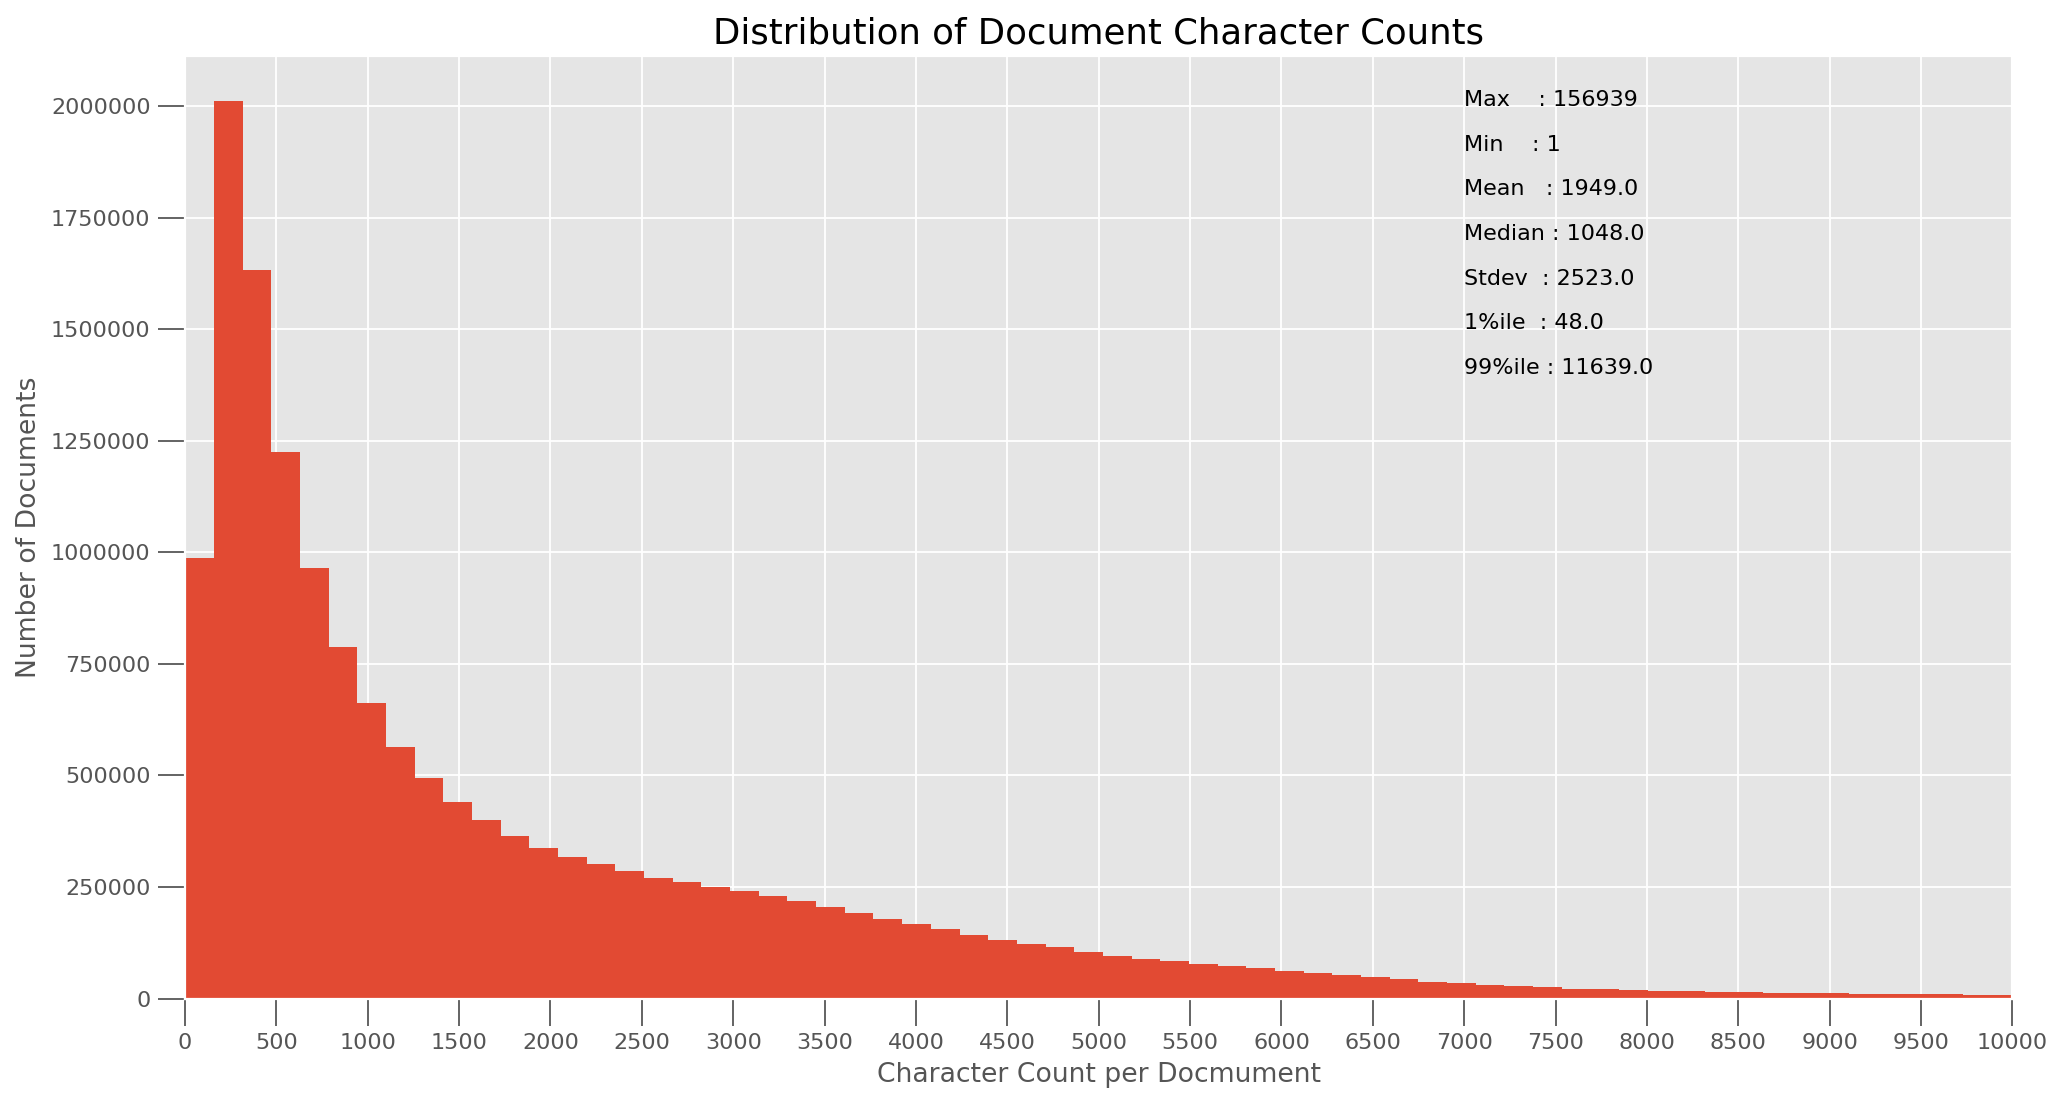

In [7]:
# Plot
plt.figure(figsize=(13,7), dpi=160)
plt.hist(length, bins = 1000)
plt.text(7000, 2000000, "Max    : " + str(round(np.max(length))))
plt.text(7000, 1900000, "Min    : " + str(round(np.min(length))))
plt.text(7000, 1800000, "Mean   : " + str(round(np.mean(length))))
plt.text(7000, 1700000, "Median : " + str(round(np.median(length))))
plt.text(7000, 1600000, "Stdev  : " + str(round(np.std(length))))
plt.text(7000, 1500000, "1%ile  : " + str(round(np.quantile(length, q=0.01))))
plt.text(7000, 1400000, "99%ile : " + str(round(np.quantile(length, q=0.99))))
plt.gca().set(xlim=(0, 10000), ylabel='Number of Documents', xlabel='Character Count per Docmument')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,10000,21))
plt.title('Distribution of Document Character Counts', fontdict=dict(size=16))
plt.tight_layout()
plt.show()

**Magnify the range of 0 to 1000 character:**

In [8]:
length1000 = [i for i in length if i <= 1000]

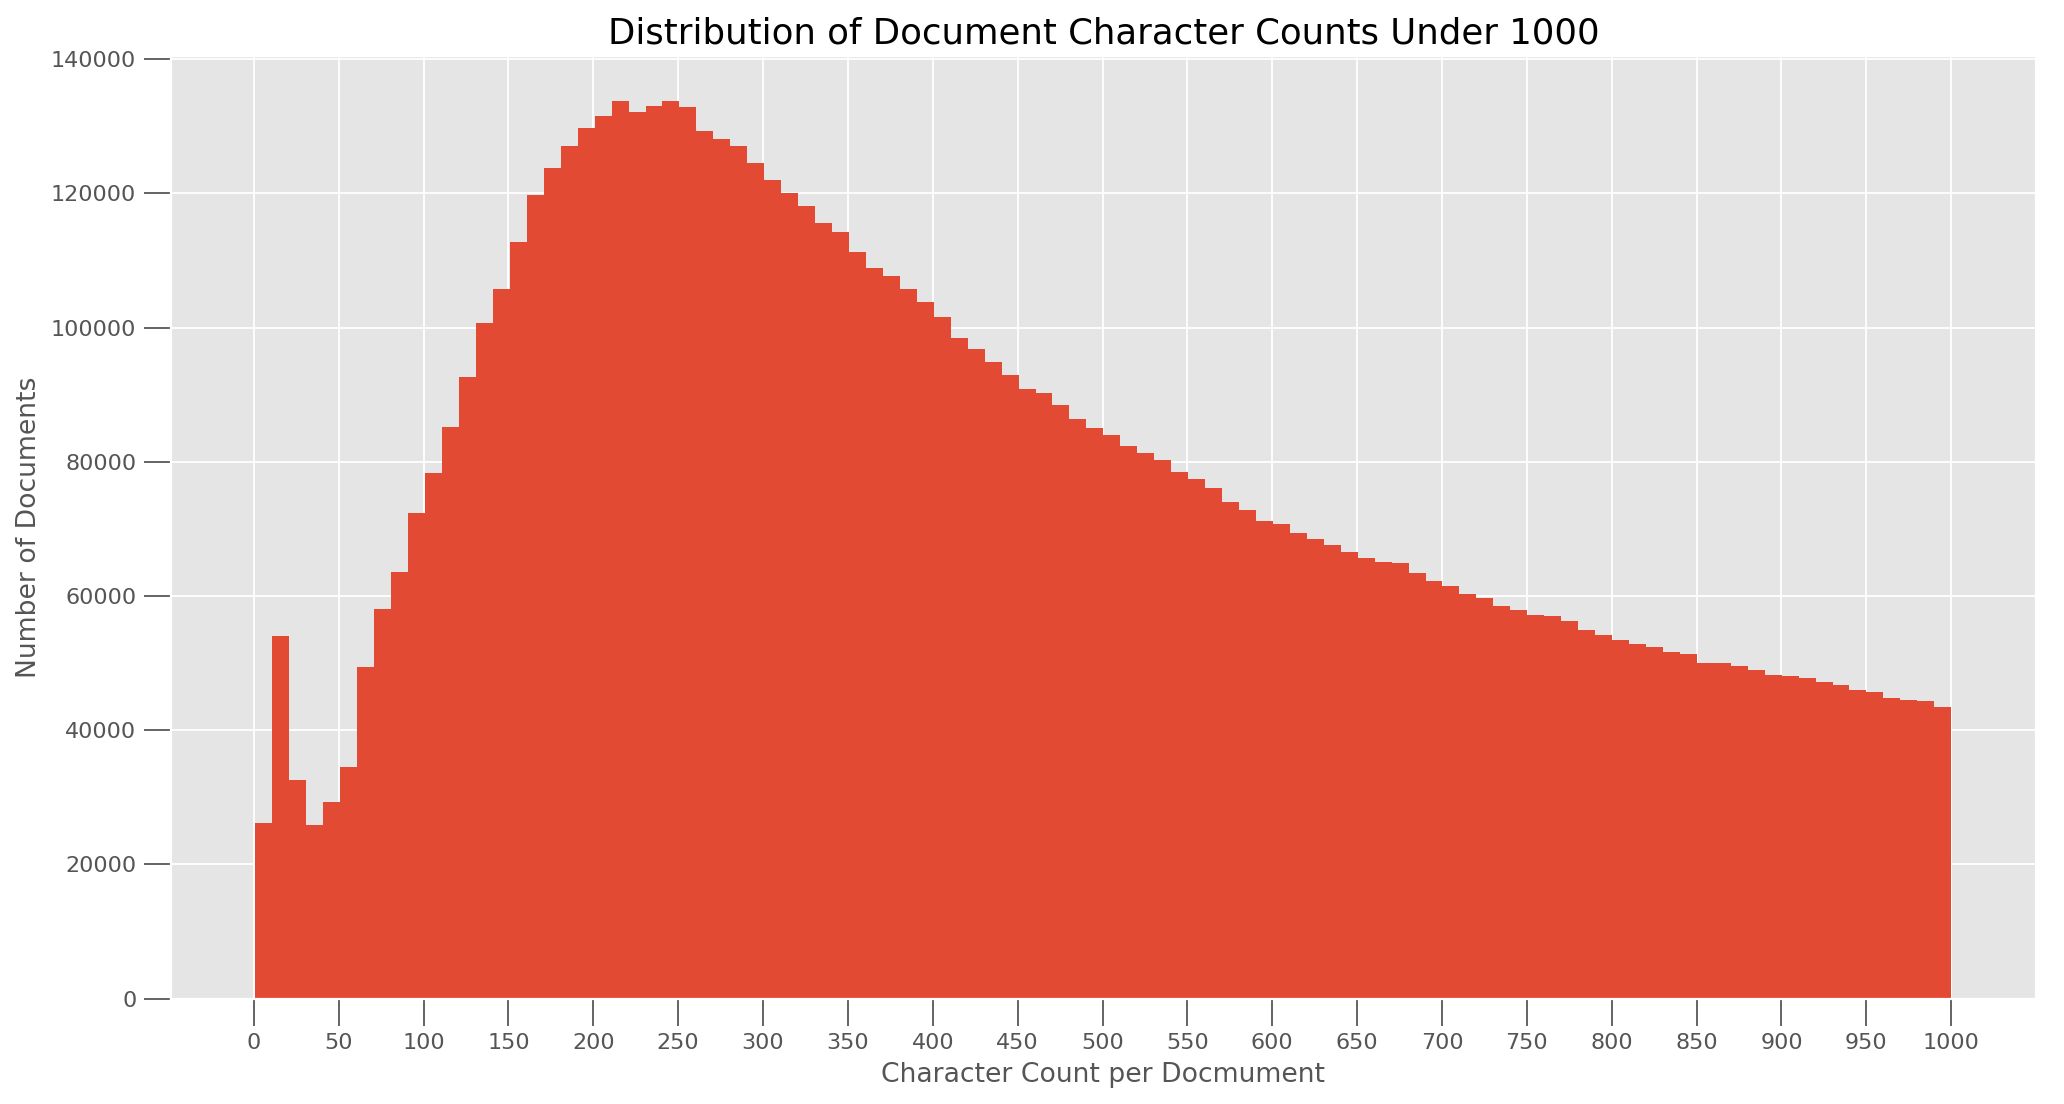

In [9]:
plt.figure(figsize=(13,7), dpi=160)
plt.hist(length1000, bins = 100)
plt.gca().set(ylabel='Number of Documents', xlabel='Character Count per Docmument')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,1000,21))
plt.title('Distribution of Document Character Counts Under 1000', fontdict=dict(size=16))
plt.tight_layout()
plt.show()

**From above plots we see that the number of documents drops rapidly when character count is under 200, consider the short text is not very useful for LDA algorithm, we set the lower limit of the outlier to 160, which means we remove documents which Character count is under 160. Please note the subject is "character" not "word", a string of 160 characters is like "From above plots we see that the number of documents drops rapidly when character count is under 200, consider the short text is not very useful for LDA algorithm", it may extract 1 or 2 topics at most, but if the topic number is over a hundred and most other text in the same corpus are much longer, the short text could be taken as a negative factor for topic modeling.**

In [6]:
min_count = 160

# remove rows with length under min_count
df = df.filter(df.length >= min_count)

In [ ]:
length_min = len([i for i in length if i < min_count])
length_all = len(length)

print('{} ({:.2f}%) samples/rows/documents were move out from dataset.'.format(length_min, 100*length_min/length_all))

1009676 (6.26%) samples/rows/documents were move out from dataset.


## 3 Extract Features

### 3.1 Date

**For history documents, it only need date as time unit, we extract "date" column from "time" column:**

In [7]:
# extract feature date
df = df.withColumn('date', df['time'].cast(DateType()))

**Check schema of the dataframe:**

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- time: string (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- date: date (nullable = true)



**Check date range has abnormal values:**

In [ ]:
start, end = df.select(F.min('date'), F.max('date')).first()
start, end

(datetime.date(1839, 8, 21), datetime.date(1945, 12, 31))

### 3.2 Advertisements

**Check "title" column to see if it is possible to extract features:**

In [9]:
df.limit(5).select('id', 'title').toPandas().head()

,id,title
0,1854224,"OUR OWN RIVER-ORUAWHARO ! (Albertland Gazette, 03 July 1862)"
1,1854742,"THE EASTERN CRISIS. (Ashburton Guardian, 11 January 1887)"
2,1855004,"SAN FRANCISCO ROUTE. (Bush Advocate, 28 July 1888)"
3,1855305,"Page 1 Advertisements Column 8 (Bush Advocate, 10 May 1888)"
4,1855374,"Page 3 Advertisements Column 5 (Bush Advocate, 10 May 1888)"


**The "title" column specified advertisements, we extract "ads" column from "title" column:**

In [8]:
# extract feature ads
df = df.withColumn('ads', df.title.contains('dvertisement'))

In [11]:
df.limit(5).select('id', 'ads', 'title').toPandas().head()

,id,ads,title
0,1854224,False,"OUR OWN RIVER-ORUAWHARO ! (Albertland Gazette, 03 July 1862)"
1,1854742,False,"THE EASTERN CRISIS. (Ashburton Guardian, 11 January 1887)"
2,1855004,False,"SAN FRANCISCO ROUTE. (Bush Advocate, 28 July 1888)"
3,1855305,True,"Page 1 Advertisements Column 8 (Bush Advocate, 10 May 1888)"
4,1855374,True,"Page 3 Advertisements Column 5 (Bush Advocate, 10 May 1888)"


### 3.3 Title

**The title consists of three parts: "real title" ("publisher", "date"), we only need "real title" part. Extract real title:**

In [9]:
# remove redandunt parts of title
df = df.withColumn('title_', F.regexp_extract(F.col('title'), '(.*)(\s\(.*\))', 1))

**Check if some titles are not the form "title ("publisher", "date"), which will lead to "title_" column is empty string:**

In [13]:
df.where(F.col('title_') == '').select(['id', 'title_', 'title']).show(5, False)

+--------+------+---------------------+
|id      |title_|title                |
+--------+------+---------------------+
|3656781 |      |Untitled Illustration|
|4832017 |      |Untitled Illustration|
|5417742 |      |Untitled Illustration|
|12676570|      |Untitled Illustration|
|23484819|      |Untitled Illustration|
+--------+------+---------------------+
only showing top 5 rows



**Change empty string in "title_" column to "Untitled Illustration":**

In [10]:
df = df.withColumn(
    'title_',
    F.when(
        F.col('title_') == '',
        F.lit('Untitled Illustration')
    ).otherwise(
        F.col('title_')
    )
)

**Print title columns:**

In [15]:
df.limit(5).select('id', 'title_', 'title').toPandas().head()

,id,title_,title
0,1854224,OUR OWN RIVER-ORUAWHARO !,"OUR OWN RIVER-ORUAWHARO ! (Albertland Gazette, 03 July 1862)"
1,1854742,THE EASTERN CRISIS.,"THE EASTERN CRISIS. (Ashburton Guardian, 11 January 1887)"
2,1855004,SAN FRANCISCO ROUTE.,"SAN FRANCISCO ROUTE. (Bush Advocate, 28 July 1888)"
3,1855305,Page 1 Advertisements Column 8,"Page 1 Advertisements Column 8 (Bush Advocate, 10 May 1888)"
4,1855374,Page 3 Advertisements Column 5,"Page 3 Advertisements Column 5 (Bush Advocate, 10 May 1888)"


### 3.4 Region

**In the website of [Papers Past](https://paperspast.natlib.govt.nz), we could find the publisher-region relationship in the [Explore all newspapers](https://paperspast.natlib.govt.nz/newspapers/all#region) webpage. Based on this webpage, we could extract region feature from "publisher" column. Here we saved [the webpage](https://paperspast.natlib.govt.nz/newspapers/all#region) and crawling the publisher-region relationship into a dataframe for extract feature.**

In [16]:
# read region.csv if start from here and omit below code until save the region dataframe.

#path = r'../temp/region.csv'
#
#data_schema = StructType([
#    StructField('publisher_', StringType()),
#    StructField('region', StringType())
#])
#
#df_region = (
#    spark.read.format("com.databricks.spark.csv")
#    .option("header", "false")
#    .option("inferSchema", "false")
#    .option("delimiter", "\t")
#    .schema(data_schema)
#    .load(path)
#)

In [11]:
from bs4 import BeautifulSoup

# read webpage
path = r'../temp/Papers Past _ Explore all newspapers.html'
with open(path, 'r') as f:
    html = f.read()

# get table 
soup = BeautifulSoup(html, "html.parser")
table = soup.find('table', attrs={'class':'table datatable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)

# transform table to pandas dataframe
df_region = pd.DataFrame(res, columns=['publisher_', 'region', 'start_', 'end_']) # column_ means it will be drop later

# transform pandas dataframe to pyspark dataframe
df_region = spark.createDataFrame(df_region).orderBy('region')

In [18]:
print('Shape of dataframe: ({}, {})'.format(df_region.count(), len(df_region.columns)))
df_region.limit(5).toPandas().head()

Shape of dataframe: (148, 4)


,publisher_,region,start_,end_
0,Kaipara and Waitemata Echo,Auckland,1911,1921
1,New Zealand Herald,Auckland,1863,1945
2,New Zealander,Auckland,1845,1866
3,New Zealand Herald and Auckland Gazette,Auckland,1841,1842
4,Observer,Auckland,1880,1920


**Notice that in this publisher-region relationship dataframe, there are two publisher's name is not identical with the dataset: "Bay Of Plenty Times" mismatch by "of", "New Zealand Free Lance" mismatch by "New Zeland", so we modify the** `df_region` **to make it identical with dataset:**

In [19]:
(df_region.filter((df_region.publisher_ == 'Bay of Plenty Times')
                 | (df_region.publisher_ == 'Free Lance'))
 .show(10, False))

+-------------------+-------------+------+----+
|publisher_         |region       |start_|end_|
+-------------------+-------------+------+----+
|Bay of Plenty Times|Bay of Plenty|1872  |1949|
|Free Lance         |Wellington   |1900  |1920|
+-------------------+-------------+------+----+



In [12]:
# update df_region for Bay Of Plenty Times and New Zealand Free Lance
df_region = df_region.withColumn(
    'publisher_',
    F.when(
        F.col('publisher_') == 'Bay of Plenty Times',
        F.lit('Bay Of Plenty Times')
    ).otherwise(
        F.col('publisher_')
    )
).withColumn(
    'publisher_',
    F.when(
        F.col('publisher_') == 'Free Lance',
        F.lit('New Zealand Free Lance')
    ).otherwise(
        F.col('publisher_')
    )
)

**Check if the two publishers' name were modified:**

In [21]:
(df_region.filter((df_region.publisher_ == 'Bay Of Plenty Times')
                 | (df_region.publisher_ == 'New Zealand Free Lance'))
 .show(10, False))

+----------------------+-------------+------+----+
|publisher_            |region       |start_|end_|
+----------------------+-------------+------+----+
|Bay Of Plenty Times   |Bay of Plenty|1872  |1949|
|New Zealand Free Lance|Wellington   |1900  |1920|
+----------------------+-------------+------+----+



**Save the region dataframe for later use:**

In [22]:
path = r'../temp/region.csv'

(df_region.select(F.col('publisher_'),
                  F.col('region'))
 .toPandas()
 .to_csv(path, header=False, index=False, encoding='utf-8'))

**Extract region column, and abandon redundant columns:**

In [13]:
df = (df.join(df_region, df.publisher == df_region.publisher_, how='left')
      .select(F.col('id'), 
              F.col('publisher'), 
              F.col('region'), 
              F.col('date'), 
              F.col('ads'), 
              F.col('title_').alias('title'), 
              F.col('content'))
      .orderBy('id')
      )

**Imputing missing value in region column with "unknwon":**

In [14]:
df = df.na.fill({'region':'unknown'})

**Check if miss any field or element:**

In [25]:
print('Print Null and empty string:')
df.select([F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c))
           .alias(c) for c in df.columns]).show()

Print Null and empty string:
+---+---------+------+----+---+-----+-------+
| id|publisher|region|date|ads|title|content|
+---+---------+------+----+---+-----+-------+
|  0|        0|     0|   0|  0|    0|      0|
+---+---------+------+----+---+-----+-------+



**Check dataframe szie:**

In [26]:
nrow = df.count()
print('Shape of dataframe: ({}, {})'.format(nrow, len(df.columns)))
print('usable line percentage:', nrow/nrow_raw)
print('removed line number:', nrow_raw - nrow)   

Shape of dataframe: (15121970, 7)
usable line percentage: 0.9037981952449434
removed line number: 1609608


**After data wrangling, there are:**
* 15,121,970 (90.4%) samples/rows/lines/documents usable, 
* 1,609,608 samples/rows/lines/documents were removed.

**Print schema and dataframe:**

In [ ]:
df.printSchema()
df.limit(5).toPandas().head()

root
 |-- id: integer (nullable = true)
 |-- publisher: string (nullable = true)
 |-- region: string (nullable = false)
 |-- date: date (nullable = true)
 |-- ads: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)



,id,publisher,region,date,ads,title,content
0,1854213,Albertland Gazette,Auckland,1862-06-14,False,TO OUR HEADERS.,TO OUR HEADERS.; We have to apologize to our. numerous for the delay which has occurred in ' getting out the first n...
1,1854214,Albertland Gazette,Auckland,1862-06-14,False,"GOD REST THEE, WEARY TRAVELLER.""","""GOD REST THEE, WEARY TRAVELLER."";■ So spake a worn pilgrim, days bygone, as he passed a pilgrim-brother bound for P..."
2,1854215,Albertland Gazette,Auckland,1862-06-14,True,Page 1 Advertisements Column 1,"v-/ .ADVERTISEMENTS. •- I Advertisements will he inserted in the y ""Gazette"" at the nominal rate of Threepence for f..."
3,1854216,Albertland Gazette,Auckland,1862-06-14,False,Correspondence.,"Correspondence.Ship "" MatildavWattenbacti;"" June G,18G2. ■ Dear Sir, ■ •■ .' ... ..,. Hearing that it is .your inten..."
4,1854218,Albertland Gazette,Auckland,1862-06-14,False,General News.,"General News.lV AMus£MENTS.--^Our record of small events laymild be incomplete, did we not mention some Kf the games..."


## 4 Save Dataset

**This dataframe would be our final dataset to generate training data and subset to analyze and visualize, we save it as compressed csv file for later processes.**

In [ ]:
path = r'../data/dataset/clean/'
df.write.csv(path, mode='overwrite', compression='gzip')

**Check the clean dataset size:**

In [2]:
path = r'../data/papers_past'
print('raw   dataset size:', subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8'))
path = r'../data/dataset/clean'
print('clean dataset size:', subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8'))

raw   dataset size: 33G
clean dataset size: 14G


**After data clean and data wrangling, the dataset size was reduced from 33GB to 14GB.**

---

In [ ]:
sc.stop()
gc.collect()